In [1]:
import numpy as np
import glob

from annoy import AnnoyIndex

import torch
import torch.nn as nn

from torchsummary import summary

import matplotlib.pyplot as plt

In [2]:
gameName = "loderunner"
rowLength = 32
numOfRows = 22

In [3]:
lrEmbeddingPath = f"testrep/{gameName}"

In [21]:
columnRefArray = np.array([np.arange(1, 32) for i in range(numOfRows+5)]).flatten()
print(columnRefArray)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13
 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6
  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9
 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2
  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

In [5]:
lrEmbeddingPaths = sorted(glob.glob(f"testrep/{gameName}/level*.npy"))

In [39]:
import shutil
shutil.rmtree("lrLSTMData/batch1")

In [46]:
import shutil
import os

if os.path.isdir("lrLSTMData"):
    shutil.rmtree("lrLSTMData/")

os.mkdir("lrLSTMData/")

padSize = rowLength * 3 # lode runner row length * 3 as paper uses previous 3 rows for lstm
N = padSize

sosArray = np.ones(shape=(1, 256)) * 9
eosArray = np.ones(shape=(1, 256)) * 5

xTrain = []
yTrain = []
xTrainTargetIn = []
columnRef = []

batchNum = 0

for i, levelEmbeddingPath in enumerate(lrEmbeddingPaths):

    levelEmbeddingArray = np.load(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = (N - j) if j < N else 0
        RowCutOff = 0 if j <= N else RowCutOff+1
        # print(f"RowCutOff: {RowCutOff}")
        # print(f"j: {j}, N: {N}")
        # print(j < N)
        # print(padLength)

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[RowCutOff:j]), axis=0)
        # print(f"dataI shape: {dataI.shape}")

        dataT = levelEmbeddingArray[j:j+N]
        targetIn = np.concatenate((sosArray, dataT))
        targetOut = np.concatenate((dataT, eosArray))

        #levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[RowCutOff:j]), axis=0)
        levelIdx = np.array(columnRefArray[j:N+j])
        dataC = np.zeros(shape=(N, 256))
        for t in range(N): dataC[t][int(levelIdx[t])] = 1
        # print(f"dataC shape: {dataC.shape} : {dataC[-1]}")

        columnRef.append(dataC)
        xTrain.append(dataI)
        xTrainTargetIn.append(targetIn)
        yTrain.append(targetOut)

    if len(xTrain) / 32 >= 100.0:

        savePath = f"lrLSTMData/batch{batchNum}"

        np.save(f"{savePath}xTrain.npy", np.array(xTrain))
        np.save(f"{savePath}xTrainTargetIn.npy", np.array(xTrainTargetIn))
        np.save(f"{savePath}yTrain.npy", np.array(yTrain))
        np.save(f"{savePath}columnRef.npy", np.array(columnRef))

        xTrain = []
        yTrain = []
        xTrainTargetIn = []
        columnRef = []

        batchNum += 1

if len(xTrain) > 0:

    savePath = f"lrLSTMData/batch{batchNum}"

    np.save(f"{savePath}xTrain.npy", np.array(xTrain))
    np.save(f"{savePath}xTrainTargetIn.npy", np.array(xTrainTargetIn))
    np.save(f"{savePath}yTrain.npy", np.array(yTrain))
    np.save(f"{savePath}columnRef.npy", np.array(columnRef))


# xTrain = np.array(xTrain)
# xTrainTargetIn = np.array(xTrainTargetIn)
# yTrain = np.array(yTrain)
# columnRef = np.array(columnRef)

In [24]:
class LSTMModel(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.histLSTM = nn.LSTM(256, 128, batch_first=True)
        self.colLSTM = nn.LSTM(256, 128, batch_first=True)

        self.textLSTM = nn.LSTM(256, 128, batch_first=True)
        self.infTextLSTM = nn.LSTM(256, 128, batch_first=True)

        self.outputLayer = nn.Linear(128, 256)

    def forward(self, xHist, xText, xCol):
        
        histOut, (histH, histC) = self.histLSTM(xHist)

        #print(f"hist out shape b4: {histOut.size()}")
        #histOut = histOut[-1, :, :]
        #print(f"hist out shape b4: {histOut.size()}")

        colOut, (colH, colC) = self.colLSTM(xCol)

        #colOut = colOut[:, -1]

        hiddenAdd = torch.add(histH, histC)
        channelAdd = torch.add(colH, colC)
        
        textOut, (textH, textC) = self.textLSTM(xText, (hiddenAdd, channelAdd))

        # print(f"text out size b4: {textOut.size()}")
        # if textOut.ndim == 2:
        #     textOut = textOut[-1, :]
        # else:
        #     textOut = textOut[:, -1, :]
        # print(f"text out size after: {textOut.size()}")

        output = nn.functional.tanh(self.outputLayer(textOut))
        
        return output

In [25]:
def TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, epochs, batchSize):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = LSTMModel()
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, eps=1e-7)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

    criterion = nn.MSELoss()

    model.to(device)
    model.train()

    losses = []

    print(f"xTrain b4 tensor shape: {xTrain.shape}")
    #xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[2], xTrain.shape[1])
    #xTrainTargetIn = xTrainTargetIn.reshape(xTrainTargetIn.shape[0], xTrainTargetIn.shape[2], xTrainTargetIn.shape[1])
    #yTrain = yTrain.reshape(yTrain.shape[0], yTrain.shape[2], yTrain.shape[1])
    #columnRef = columnRef.reshape(columnRef.shape[0], columnRef.shape[2], columnRef.shape[1])

    for i in range(epochs):

        losses.append([])

        for j in range(0, xTrain.shape[0], batchSize):
            
            xTrainTensor = torch.tensor(xTrain[j:j+batchSize], dtype=torch.float32).to(device)
            xTrainTargetInTensor = torch.tensor(xTrainTargetIn[j:j+batchSize], dtype=torch.float32).to(device)

            yTrainTensor = torch.tensor(yTrain[j:j+batchSize], dtype=torch.float32).to(device)

            columnRefTensor = torch.tensor(columnRef[j:j+batchSize], dtype=torch.float32).to(device)

            # print(xTrainTensor.shape)
            # print(xTrainTargetInTensor.shape)
            # print(yTrainTensor.shape)
            # print(columnRefTensor.shape)

            #print(f"xTrain size: {xTrainTensor.size()}")

            yPred = model(xTrainTensor, xTrainTargetInTensor, columnRefTensor)
            
            #print(f"yPred size: {yPred.size()}")
            #print(f"yTruth size: {yTrainTensor.size()}")
            loss = criterion(yPred, yTrainTensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i].append(loss.cpu().detach().item())

        print(f"Epoch {i}: loss {sum(losses[i])/len(losses[i])}")
    
    return model

In [ ]:
model = TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, 25, 32)

In [58]:
sorted(glob.glob(f"lrLSTMData/*"))

['lrLSTMData/batch0columnRef.npy',
 'lrLSTMData/batch0xTrain.npy',
 'lrLSTMData/batch0xTrainTargetIn.npy',
 'lrLSTMData/batch0yTrain.npy',
 'lrLSTMData/batch10columnRef.npy',
 'lrLSTMData/batch10xTrain.npy',
 'lrLSTMData/batch10xTrainTargetIn.npy',
 'lrLSTMData/batch10yTrain.npy',
 'lrLSTMData/batch11columnRef.npy',
 'lrLSTMData/batch11xTrain.npy',
 'lrLSTMData/batch11xTrainTargetIn.npy',
 'lrLSTMData/batch11yTrain.npy',
 'lrLSTMData/batch12columnRef.npy',
 'lrLSTMData/batch12xTrain.npy',
 'lrLSTMData/batch12xTrainTargetIn.npy',
 'lrLSTMData/batch12yTrain.npy',
 'lrLSTMData/batch13columnRef.npy',
 'lrLSTMData/batch13xTrain.npy',
 'lrLSTMData/batch13xTrainTargetIn.npy',
 'lrLSTMData/batch13yTrain.npy',
 'lrLSTMData/batch14columnRef.npy',
 'lrLSTMData/batch14xTrain.npy',
 'lrLSTMData/batch14xTrainTargetIn.npy',
 'lrLSTMData/batch14yTrain.npy',
 'lrLSTMData/batch15columnRef.npy',
 'lrLSTMData/batch15xTrain.npy',
 'lrLSTMData/batch15xTrainTargetIn.npy',
 'lrLSTMData/batch15yTrain.npy',
 'l

In [60]:
batchPaths = sorted(glob.glob(f"lrLSTMData/*"))

for i in range(0, len(batchPaths), 4):
    print(i)
    print(batchPaths[i:i+4])

0
['lrLSTMData/batch0columnRef.npy', 'lrLSTMData/batch0xTrain.npy', 'lrLSTMData/batch0xTrainTargetIn.npy', 'lrLSTMData/batch0yTrain.npy']
4
['lrLSTMData/batch10columnRef.npy', 'lrLSTMData/batch10xTrain.npy', 'lrLSTMData/batch10xTrainTargetIn.npy', 'lrLSTMData/batch10yTrain.npy']
8
['lrLSTMData/batch11columnRef.npy', 'lrLSTMData/batch11xTrain.npy', 'lrLSTMData/batch11xTrainTargetIn.npy', 'lrLSTMData/batch11yTrain.npy']
12
['lrLSTMData/batch12columnRef.npy', 'lrLSTMData/batch12xTrain.npy', 'lrLSTMData/batch12xTrainTargetIn.npy', 'lrLSTMData/batch12yTrain.npy']
16
['lrLSTMData/batch13columnRef.npy', 'lrLSTMData/batch13xTrain.npy', 'lrLSTMData/batch13xTrainTargetIn.npy', 'lrLSTMData/batch13yTrain.npy']
20
['lrLSTMData/batch14columnRef.npy', 'lrLSTMData/batch14xTrain.npy', 'lrLSTMData/batch14xTrainTargetIn.npy', 'lrLSTMData/batch14yTrain.npy']
24
['lrLSTMData/batch15columnRef.npy', 'lrLSTMData/batch15xTrain.npy', 'lrLSTMData/batch15xTrainTargetIn.npy', 'lrLSTMData/batch15yTrain.npy']
28
['l

In [65]:
def TrainModelFromFiles(batchPaths, epochs, batchSize):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = LSTMModel()
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, eps=1e-7)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

    criterion = nn.MSELoss()

    model.to(device)
    model.train()

    losses = []

    for i in range(epochs):

        losses.append([])

        for t in range(0, len(batchPaths), 4):
            print(t)
            print(batchPaths[t:t+4])

            xTrain = np.load(batchPaths[t+1])
            xTrainTargetIn = np.load(batchPaths[t+2])
            yTrain = np.load(batchPaths[t+3])
            columnRef = np.load(batchPaths[t])

            for j in range(0, xTrain.shape[0], batchSize):
                
                xTrainTensor = torch.tensor(xTrain[j:j+batchSize], dtype=torch.float32).to(device)
                xTrainTargetInTensor = torch.tensor(xTrainTargetIn[j:j+batchSize], dtype=torch.float32).to(device)

                yTrainTensor = torch.tensor(yTrain[j:j+batchSize], dtype=torch.float32).to(device)

                columnRefTensor = torch.tensor(columnRef[j:j+batchSize], dtype=torch.float32).to(device)

                # print(xTrainTensor.shape)
                # print(xTrainTargetInTensor.shape)
                # print(yTrainTensor.shape)
                # print(columnRefTensor.shape)

                #print(f"xTrain size: {xTrainTensor.size()}")

                yPred = model(xTrainTensor, xTrainTargetInTensor, columnRefTensor)
                
                #print(f"yPred size: {yPred.size()}")
                #print(f"yTruth size: {yTrainTensor.size()}")
                loss = criterion(yPred, yTrainTensor)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses[i].append(loss.cpu().detach().item())

        print(f"Epoch {i}: loss {sum(losses[i])/len(losses[i])}")
    
    return model

In [66]:
model = TrainModelFromFiles(batchPaths, 25, 32)

0
['lrLSTMData/batch0columnRef.npy', 'lrLSTMData/batch0xTrain.npy', 'lrLSTMData/batch0xTrainTargetIn.npy', 'lrLSTMData/batch0yTrain.npy']
4
['lrLSTMData/batch10columnRef.npy', 'lrLSTMData/batch10xTrain.npy', 'lrLSTMData/batch10xTrainTargetIn.npy', 'lrLSTMData/batch10yTrain.npy']
8
['lrLSTMData/batch11columnRef.npy', 'lrLSTMData/batch11xTrain.npy', 'lrLSTMData/batch11xTrainTargetIn.npy', 'lrLSTMData/batch11yTrain.npy']
12
['lrLSTMData/batch12columnRef.npy', 'lrLSTMData/batch12xTrain.npy', 'lrLSTMData/batch12xTrainTargetIn.npy', 'lrLSTMData/batch12yTrain.npy']
16
['lrLSTMData/batch13columnRef.npy', 'lrLSTMData/batch13xTrain.npy', 'lrLSTMData/batch13xTrainTargetIn.npy', 'lrLSTMData/batch13yTrain.npy']
20
['lrLSTMData/batch14columnRef.npy', 'lrLSTMData/batch14xTrain.npy', 'lrLSTMData/batch14xTrainTargetIn.npy', 'lrLSTMData/batch14yTrain.npy']
24
['lrLSTMData/batch15columnRef.npy', 'lrLSTMData/batch15xTrain.npy', 'lrLSTMData/batch15xTrainTargetIn.npy', 'lrLSTMData/batch15yTrain.npy']
28
['l

In [10]:
total = 0
for name, param in model.named_parameters():
    print(f"{name:<24}: {param.numel():5}")
    total += param.numel()

print(f"Total Params: {total}")

histLSTM.weight_ih_l0   : 131072
histLSTM.weight_hh_l0   : 65536
histLSTM.bias_ih_l0     :   512
histLSTM.bias_hh_l0     :   512
colLSTM.weight_ih_l0    : 131072
colLSTM.weight_hh_l0    : 65536
colLSTM.bias_ih_l0      :   512
colLSTM.bias_hh_l0      :   512
textLSTM.weight_ih_l0   : 131072
textLSTM.weight_hh_l0   : 65536
textLSTM.bias_ih_l0     :   512
textLSTM.bias_hh_l0     :   512
infTextLSTM.weight_ih_l0: 131072
infTextLSTM.weight_hh_l0: 65536
infTextLSTM.bias_ih_l0  :   512
infTextLSTM.bias_hh_l0  :   512
outputLayer.weight      : 32768
outputLayer.bias        :   256
Total Params: 823552


tileMap shape: (105600, 16, 16, 3)
embedMap shape: (105600, 256)
Maps Loaded
Initialised Tree
Building Tree
Tree Built
Annoy Map Trained
Random Start Point: 8
Input shape: (608, 96, 256)
input size: torch.Size([96, 256])
target shape: (608, 96, 256)
target size: torch.Size([96, 256])
column shape: (608, 96, 256)
column size: torch.Size([96, 256])
Running Model
next col size: (96, 256)
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
73252
73252
73252
73252
73252
73252
73252
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
73252
73252
73252
73252
73252
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
73252
73252
73252
73252
73252
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
49320
73252
49320
73252
49320
49320


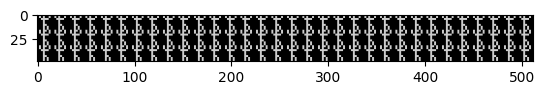

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

tileMap = np.load(f"testrep/{gameName}/centerTiles.npy")
embedMap = np.load(f"testrep/{gameName}/embeddings.npy")

print(f"tileMap shape: {tileMap.shape}")
print(f"embedMap shape: {embedMap.shape}")

print("Maps Loaded")

nnTree = AnnoyIndex(256, 'euclidean')

print("Initialised Tree")

#for i in range(embedMap.shape[0]): print(f"Added {i}th item to tree"), nnTree.add_item(i, embedMap[i])
for i in range(embedMap.shape[0]): nnTree.add_item(i, embedMap[i])

print("Building Tree")
nnTree.build(15)
print("Tree Built")

print("Annoy Map Trained")

padSize = rowLength * 3 # lode runner row length * 3 as paper uses previous 3 rows for lstm
N = padSize

NLevels = 1

np.random.seed(100)
randStartPoint = np.random.randint(0, len(lrEmbeddingPaths)-NLevels)
print(f"Random Start Point: {randStartPoint}")

for i, levelEmbeddingPath in enumerate(lrEmbeddingPaths[randStartPoint:randStartPoint+NLevels]):

    input = []
    column = []
    target = []

    levelEmbeddingArray = np.load(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = (N - j) if j < N else 0
        RowCutOff = 0 if j <= N else RowCutOff+1

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[RowCutOff:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[RowCutOff:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    input = np.array(input)
    print(f"Input shape: {input.shape}")
    #input = torch.tensor(input[0].reshape(256, N), dtype=torch.float32).to(device)
    input = torch.tensor(input[0], dtype=torch.float32).to(device)
    print(f"input size: {input.size()}")

    target = np.array(target)
    print(f"target shape: {target.shape}")
    #target = torch.tensor(target[0].reshape(256, N), dtype=torch.float32).to(device)
    target = torch.tensor(target[0], dtype=torch.float32).to(device)
    print(f"target size: {target.size()}")

    column = np.array(column)
    print(f"column shape: {column.shape}")
    #column = torch.tensor(column[0].reshape(256, N), dtype=torch.float32).to(device)
    column = torch.tensor(column[0], dtype=torch.float32).to(device)
    print(f"column size: {column.size()}")

    print("Running Model")

    nextCol = model(input, target, column)
    nextCol = nextCol.cpu().detach().numpy()
    print(f"next col size: {nextCol.shape}")
    #nextCol = nextCol[:, :78].reshape(6, 13, nextCol.shape[0]).transpose(1, 0, 2)

    # this reshape line is specific to bobble bubble as the level is in column wise order and only contains half the level needing to be mirrored
    # Make this compatible with lode runner
    # nextCol = nextCol.reshape(6, 13, nextCol.shape[1]).transpose(1, 0, 2)

    nextCol = nextCol.reshape(3, 32, nextCol.shape[1])

    levelImage = np.zeros(shape=(nextCol.shape[0] * 16, nextCol.shape[1] * 16, 3), dtype=np.uint8)

    for t, row in enumerate(nextCol):
        for j, embedding in enumerate(row):

            nearestEmbedding = nnTree.get_nns_by_vector(embedding, 2, search_k=-1, include_distances=False)[0]
            print(nearestEmbedding)
            tileImage = tileMap[nearestEmbedding]

            levelImage[t*16 : t*16+16, j*16 : j*16+16, :] = tileImage

    # This line is bubble bobble specific to mirror the level
    # levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1)

    plt.figure()
    plt.imshow(levelImage)